## Finding Pairwise Correlations for DepMap (20Q2) Gene-Dependencies and Gene-Effects

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

In [151]:
effect = pd.read_csv("/home/annerer/Downloads/Achilles_gene_effect.csv")

In [152]:
data = pd.read_csv("/home/annerer/Downloads/sample_info.csv")

In [153]:
mapping = {}

for i in np.arange(0,data.shape[0],1):
    mapping[data.DepMap_ID[i]] = data.CCLE_Name[i]

effect["INDEX"] = effect.DepMap_ID
effect = effect.set_index('INDEX')
effect = effect.rename(index=mapping)

effect = effect.drop("DepMap_ID",1)

gene = effect.columns.to_list()
# split at space
for i in range(len(gene)):
    gene[i] = gene[i].split(" ") 

genes = []
for i in range(len(gene)):
    genes.append(gene[i][0])
    
effect.columns = genes

### New Vectorized Correlation Functions

In [154]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean()
    B_mB = B - B.mean()

    # Sum of squares across rows
    ssA = (A_mA**2).sum()
    ssB = (B_mB**2).sum()

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA,ssB))

In [173]:
def vcorrcoef(X,y):
    Xm = X.mean()
    ym = y.mean()
    r_num = np.sum((X-Xm)*(y-ym))
    r_den = np.sqrt(np.sum((X-Xm)**2)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

In [174]:
vcorrcoef(df['TP53 (7157)'],df["MDM2 (4193)"])

-0.6967472861744265

In [ ]:
correlations = {}
for col_a, col_b in itertools.combinations(effect, 2):
    correlations[col_a + '__' + col_b] = vcorrcoef(effect[col_a],effect[col_b])

In [ ]:
result = pd.DataFrame.from_dict(correlations, orient='index')
pd.write_csv("effect_corr_pairs.csv",result)

potentially better version:

In [ ]:
# should not be needed, as the above version handles NaNs

correlations = {}
for col_a, col_b in itertools.combinations(effect, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    correlations[col_a + '__' + col_b] = vcorrcoef(effect[col_a][~nas],effect[col_b][~nas])

Im web-interface von DepMap wird von Co-Dependencies gesprochen wenn
Korrelationen von Gene-Effect-Werten gemeint sind.

In [33]:
effect['RAN (5901)'].isnull().sum()

12

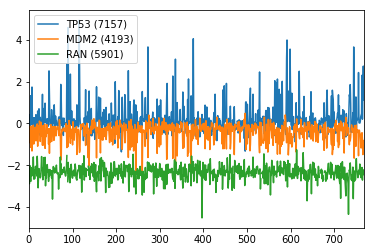

In [94]:
effect["TP53 (7157)"].plot()
effect["MDM2 (4193)"].plot()
effect["RAN (5901)"].plot()
plt.legend()
plt.savefig('comparrison_of_gene_effect_TP53_MDM2_RAN')

Korrelationsskript

In [89]:
correlations = {}
df = effect[['MDM2 (4193)','TP53 (7157)']]

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr

result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']
result

In [154]:
df = effect

In [155]:
correlations = {}
llllll
for col_a, col_b in itertools.combinations(df, 2):
    corr = df[col_a].corr(df[col_b])
    correlations[col_a + '__' + col_b] = corr
result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC']
print('done')
result.to_csv('corr_effect_pairs_full.csv')

done


In [156]:
# new names that lend themselves to further processing
result = pd.read_csv('corr_effect_pairs_full.csv')
result = result.rename(columns={'Unnamed: 0':'pairs','PCC':'PCC'})
result_sorted = result.sort_values('PCC')
result_sorted.to_csv('corr_effect_sorted.csv')

In [3]:
result = pd.read_csv('corr_effect_sorted.csv')
result.to_feather('corr_effect_sorted.feather')

In [4]:
result = pd.read_feather('corr_effect_sorted.feather')

In [13]:
top = result[result['PCC'] > 0.2]
bottom = result[result['PCC'] < -0.15]

len(top)

254830

In [17]:
top.head()

,Unnamed: 0,pairs,PCC
163885191,86439037,FLCN__WDR24,0.200000
163885192,158493669,MAP3K19__RBM43,0.200000
163885193,23096868,CAMKV__GPR139,0.200000
163885194,66641568,S100A10__UBA52,0.200001
163885195,75292798,HMX1__SORBS1,0.200001


In [27]:
top = top.drop('Unnamed: 0',1)
bottom = bottom.drop('Unnamed: 0',1)

In [28]:
bottom

,pairs,PCC
0,MDM2__TP53,-0.696747
1,MDM2__TP53BP1,-0.629534
2,PPM1D__TP53,-0.586922
3,ATM__MDM2,-0.533031
4,CHEK2__MDM2,-0.522001


In [29]:
len(bottom)
bottom.to_csv('bottom_pairwise_PCC_values.txt')
top.to_csv('top_pairwise_PCC_values.txt')

In [157]:
#length = len(result_sorted)
#result_sorted[int(np.round(0.99999*length)):length]

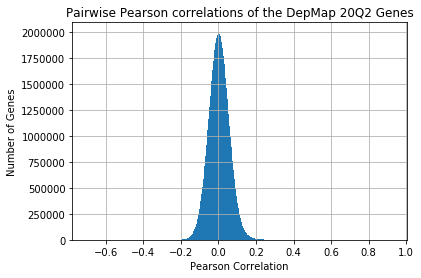

In [13]:
result_sorted['PCC'].hist(bins=1000)
plt.title("Pairwise Pearson correlations of the DepMap 20Q2 Genes")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Genes")
plt.savefig('pairwise_pcc_geneEffects')

In [158]:
result_sorted.tail(5)

,pairs,PCC
128919440,SUPT20H__TADA2B,0.854789
84835691,TADA2B__TAF5L,0.866306
104388769,TADA1__TAF5L,0.875483
114130706,SUPT20H__TAF5L,0.889404
70640086,TSC1__TSC2,0.923451


In [159]:
result_sorted.head(5)

,pairs,PCC
162996,MDM2__TP53,-0.696747
93096746,MDM2__TP53BP1,-0.629534
40699436,PPM1D__TP53,-0.586922
63121155,ATM__MDM2,-0.533031
146694450,CHEK2__MDM2,-0.522001


In [161]:
a = result_sorted.head(20)['pairs'].to_list()
b = []

for _ in a:
    b.append(_.split("__"))

In [167]:
b[2]

['PPM1D', 'TP53']

In [15]:
result = result.drop('Unnamed: 0',1)

In [16]:
list1 = []
print(result.shape)
#y = result.iloc[0]
result.head()
for _ in range(0,100):
    list1.append([result.iloc[_][0].split('__')[0],result.iloc[_][0].split('__')[1],result.iloc[_][1]])


(164140021, 2)


In [19]:
#list1

In [86]:
def tissues_from_diff(gene_a,gene_b):
    def diff(gene_a,gene_b):
        """ takes 2 genes and returns the cell lines
        for which those two genes have a high correlation
        or anticorrelation in gene effect"""
        diff = np.abs(effect[gene_a] - effect[gene_b])
        return (diff) 
    diff1 = diff(gene_a,gene_b)
    diff1_top = diff1.sort_values().tail(10).index.to_list()
    diff1_bottom = diff1.sort_values().head(10).index.to_list()
    print('first is top, second is bottom')
    return([diff1_top,diff1_bottom])

def tissues_from_sums(gene_a,gene_b):
        def summ(gene_a,gene_b):
            summ = np.abs(effect[gene_a] + effect[gene_b])
            return summ
        summ1 = summ(gene_a,gene_b)
        summ1_top = summ1.sort_values().tail(10).index.to_list()
        summ1_bottom = summ1.sort_values().head(10).index.to_list()
        print('first is top, second is bottom')
        return([summ1_top,summ1_bottom])

In [176]:
#tissues_from_sums("CHEK2","PPM1D")[1]
#tissues_from_diff("CHEK2","PPM1D")

### new plan: building a pairwise correlation network

In [139]:
data_graph = result_sorted[int(np.round(0.9999*length)):length]
strings = data_graph['pairs'].to_list()

a = []
for _ in strings:
    a.append(_.split(' '))

In [195]:
# format of the corr_data: gene pair with pearson correlation value

corr_data =([['SUPT20H', 'TADA1', 0.85],
             ['TADA1', 'TADA2B', 0.83],
             ['SUPT20H', 'TAF5L', 0.889]])

In [36]:
corr_data = list1

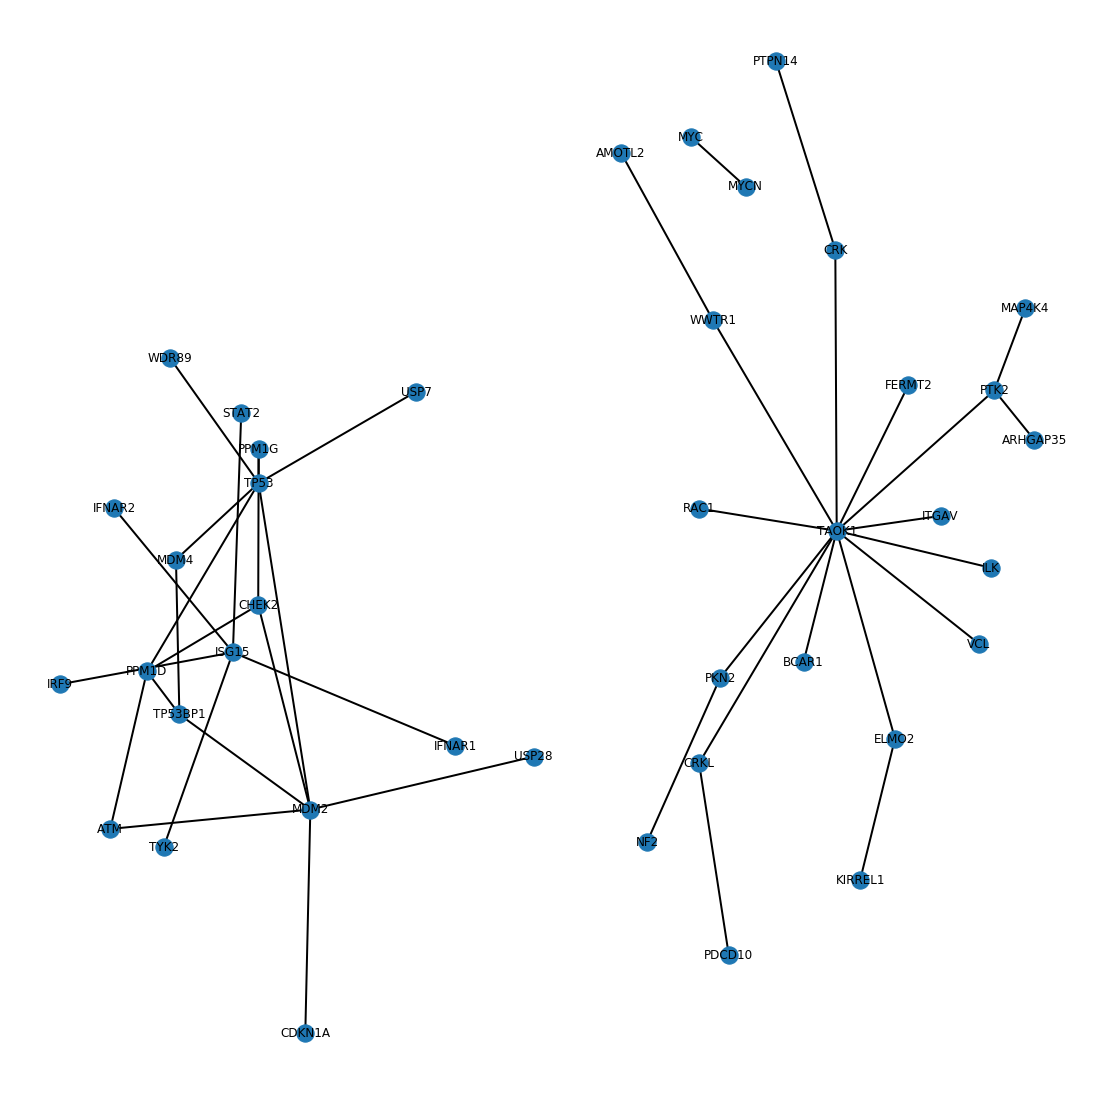

In [60]:
corr_data = list1
G=nx.Graph()
#result_sorted[int(np.round(0.99999*length)):length]
corr_data = [[x[0],x[1],1000**(x[2])] for x in corr_data]

existing_edges = {}
def build_graph(w, lev):
    if (lev > 5)  :
        return
    for z in corr_data:
        ind=-1 
        if z[0] == w:
            ind=0
        ind1=1
    if z[1] == w:
         ind ==1
         ind1 =0

    if ind == 0 or ind == 1:
        if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :

            G.add_node(str(corr_data[ind]))
            existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
            G.add_edge(w,str(corr_data[ind1]))
            build_graph(corr_data[ind1], lev+1)

    existing_nodes = {}
def build_graph_for_all():
    count=0
    for d in corr_data:
        if (count > 40) :
              return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
               G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count=count + 1

build_graph_for_all()
pos = nx.spring_layout(G)
nx.draw(G,pos=pos, width=2, with_labels=True)

plt.savefig("path2.png")
plt.rcParams["figure.figsize"] = (10,10)
#check why tp53 and mdm2 are not connected

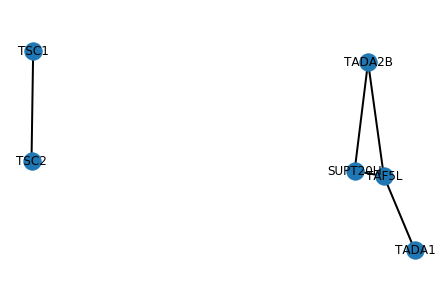

In [244]:
G=nx.Graph()
corr_data = [[x[0],x[1],1000**(x[2])] for x in corr_data]
existing_edges = {}
existing_nodes = {}
build_graph_for_all()
pos = nx.spring_layout(G,weight='weight')
nx.draw(G,pos=pos, width=2, with_labels=True)

plt.savefig("path3.png")

In [41]:
from networkx.readwrite import json_graph

G = nx.DiGraph([(1, 2)])

data = json_graph.tree_data(G, root=1)
import json

s = json.dumps(data)
s

'{"children": [{"id": 2}], "id": 1}'

Hallo Jürgen,

Die Schneckenpost ist endlich da!
1) Meine Frage dreht sich darum wie du am besten paarweise korrelierte/antikorrelatierte Werte (eg a mit b) selektieren würdest, bzw wie du den entsprechenden Cutoff ansetzen würdest.

          a b ...
          ____ 
      c1 |_|_|
      c2 |_|_|
      c3 |_|_|
       .      .
       .        .
       .          .
        
    a,b...  genes 
    c_i ... conditions
    
 
Ich habe für den oben skizzierten Datensatz eine paarweise Pearsonkorrelation berechnet und für die jeweiligen conditions (c_i) den genetischen Hintergrund ermittelt. 
Uli meinte nun wir könnten für relevante Genpaare (aus der Korrelation) die Summe und Differenz der Geneffekte (Elemente aus obiger Matrix) pro Paar finden, um so auf die stark (anti-)korrelierten zu kommen.

Ziel ist es zu sehen ob bestimmte genetische Hintergründe in den {c_i} der stark (anti-)korrelierten enriched sind.

Es stellt sich auch die Frage ob ich den Cutoff im Vorhinein festlegen sollte. Uli meinte wir könnten die Differenz gegen die Zahl der Zellen (conditions) plotten und den initialen monoton fallenden Bereich nehmen.

Eine Frage wäre: Gibt es hier ein Standardverfahren?
Ich werde den Verdacht nicht los dass ich was offensichtliches übersehe.
Wie würdest du vorgehen? 
Habe das beschriebene Verfahren bereits implementiert, es geht
mir primär darum ob es auch 'sound' ist.

2) Bezüglich des Projekts:
Hättest du (MS) paper die ich lesen sollte um einen tieferen
einblick in die Materie zu bekommen?

3) Bezüglich Mathe:
Ich würde wirklich gern mithelfen, auch ohne Entlohnung.
Hab in der Vergangenheit viel Mathe-Nachhilfe gegeben und
hab damit gute Erfahrungen gemacht. Das war auch der Grund warum 
ich dich letzte Woche darauf angesprochen habe.

Beste Grüße,
Lukas

In [75]:
df = pd.DataFrame(np.random.random((6, 6)), columns=[chr(i + ord('a')) for i in range(6)]) 
df['a'][3] = np.nan
df['b'][4] = np.nan
print(df)

          a         b         c         d         e         f
0  0.238729  0.836833  0.844553  0.673913  0.478680  0.622733
1  0.442589  0.560388  0.344260  0.724260  0.231331  0.568334
2  0.851465  0.515215  0.464266  0.561362  0.071919  0.180770
3       NaN  0.812376  0.695367  0.309487  0.826105  0.817678
4  0.846068       NaN  0.156010  0.346022  0.740878  0.211795
5  0.679405  0.830221  0.057410  0.083349  0.570318  0.862084


In [78]:
nas = np.logical_or(np.isnan(df['a']), np.isnan(df['b']))
df['a'][~nas]

0    0.238729
1    0.442589
2    0.851465
5    0.679405
Name: a, dtype: float64

In [ ]:
correlations = {}

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr

    
result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']
result.to_csv('effect_pairs.csv')

In [73]:
myarray = np.array([1,2,3,4,5,6,7,8,9,10])
zipped_array = zip(myarray[::2], myarray[1::2])
list(zipped_array)

[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10)]

### Get the shoulder from the sorted PCC DataFrame

### Pandas stellt die Importierten Daten nicht in ihrer vollen Laenge dar. Bei Berechnungen werden die 50+ Nachkommastellen jedoch verwendet

In [ ]:
#with pd.option_context('display.precision', 50):
#    print(dep['TP53 (7157)'].sort_values())

## Wichtiges Snippet. Berechnung der Korrelation wobei ich keinen Wert nehmen wenn einer der Partner NaN ist.

In [ ]:
#dep_corr = dep.corr()

for i in range(len(effect.columns)):    
    x, y = effect.iloc[ :,i].values,
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    corr = pearsonr(x[~nas], y[~nas])
    correlation.append(corr)

In [10]:
print(dep['RAN (5901)'].isnull().sum())
print(dep['CDKN1A (1026)'].isnull().sum())
print(dep['MDM2 (4193)'].isnull().sum())

12
0
0


In [7]:
pearsonr(dep['TP53 (7157)'],dep['CDKN1A (1026)'])

(0.23544082592466523, 3.8041061892119593e-11)

In [9]:
pearsonr(dep['TP53 (7157)'],dep['MDM2 (4193)'])

(-0.3512264810233069, 9.590539022551798e-24)

In [95]:
#dep['MDM2 (4193)'].sort_values()

In [21]:
dep.shape

(769, 18119)

In [32]:
dep2 = dep

In [6]:
#dep = dep.drop('DepMap_ID',1)

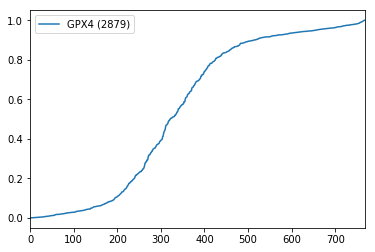

In [109]:
gpx = dep["GPX4 (2879)"].sort_values()
gpx = gpx.reset_index()
gpx = gpx.drop('index',1)
gpx.plot()

In [6]:
# the matrix
correlations = dep.corr()

In [4]:
sci.stats.pearsonr(dep['A2M (2)'][1:4],dep['A2M (2)'][1:4])

(1.0, 0.0)

In [7]:
#sci.stats.pearsonr(dep.columns.values,dep.columns.values)

In [38]:
#correlations[["A2M (2)"]].sort_values(by=['A2M (2)'])

## Test Data fuer die Korrelation

In [4]:
df = pd.DataFrame(np.random.random((6, 6)), columns=['gene_' + chr(i + ord('a')) for i in range(6)]) 
print(df)

     gene_a    gene_b    gene_c    gene_d    gene_e    gene_f
0  0.735955  0.400680  0.246593  0.913273  0.747246  0.791465
1  0.547346  0.072919  0.933062  0.232660  0.377221  0.343400
2  0.654725  0.641919  0.297961  0.912088  0.441782  0.587996
3  0.896772  0.286375  0.721536  0.371457  0.258281  0.909784
4  0.756991  0.024119  0.475772  0.969679  0.989577  0.244825
5  0.597021  0.679071  0.642593  0.648500  0.951326  0.211457


In [28]:
query = df.query('gene_a > gene_b').iloc[::,0:2]
query.index.to_list()

[0, 2, 5]

In [6]:
def get_conditions(df):
    # return row in which ga pairwise_correlation is higher than the average 
    result = df[(df.gene_a < df.gene_b) & (df.gene_a < df.gene_c) & (df.gene_a < df.gene_d)]
    return result.index.to_list()
    

In [7]:
get_conditions(df)

[5]

In [49]:
new = ['avana',"plana",0,'quana',1,'tana']
df = df.reindex(new, fill_value=0)

,level_0,index,gene_a,gene_b,gene_c,gene_d,gene_e,gene_f
avana,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
plana,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0,0,0.735955,0.400680,0.246593,0.913273,0.747246,0.791465
quana,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,0.547346,0.072919,0.933062,0.232660,0.377221,0.343400
tana,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [55]:
df = df.T
df.rename(columns={0:'atg',1:'pln'})

,atg,pln,2,3,4,5
level_0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
index,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000
gene_a,0.735955,0.547346,0.654725,0.896772,0.756991,0.597021
gene_b,0.400680,0.072919,0.641919,0.286375,0.024119,0.679071
gene_c,0.246593,0.933062,0.297961,0.721536,0.475772,0.642593
gene_d,0.913273,0.232660,0.912088,0.371457,0.969679,0.648500
gene_e,0.747246,0.377221,0.441782,0.258281,0.989577,0.951326
gene_f,0.791465,0.343400,0.587996,0.909784,0.244825,0.211457


check out biclustering.

find a way to return indices of relevant genes


In [20]:
data = pd.read_csv("/home/annerer/Downloads/sample_info.csv")

## Umbenennen der Zelllinien. 

siehe querrying depmap

In [21]:
mapping = {}

for i in np.arange(0,data.shape[0],1):
    mapping[data.DepMap_ID[i]] = data.CCLE_Name[i]

#mappign = data[['CCLE_Name','DepMap_ID']].to_dict()

In [121]:
dep = pd.read_csv("/home/annerer/Downloads/Achilles_gene_dependency.csv")

In [123]:
dep["new_index"] = dep.DepMap_ID
dep = dep.set_index('new_index')

In [124]:
dep = dep.rename(index=mapping)

password for phosphosite:

EfBGWYFFN8UtbAi

In [58]:
#df = pd.DataFrame(np.random.randn(10, 2), columns=list('ab'))
#df.query('a > b')

In [41]:
df = pd.DataFrame(np.random.random((6, 6)), columns=['gene_' + chr(i + ord('a')) for i in range(6)]) 
print(df)
df['gene_a'][3] = np.nan
df['gene_d'][4] = np.nan
df['gene_c'][2] = np.nan
df['gene_f'][1] = np.nan

     gene_a    gene_b    gene_c    gene_d    gene_e    gene_f
0  0.665301  0.869902  0.879890  0.169911  0.608579  0.341876
1  0.277930  0.497177  0.199557  0.956748  0.328038  0.248854
2  0.438563  0.367788  0.437718  0.481967  0.745440  0.861007
3  0.878028  0.214308  0.532944  0.560893  0.383670  0.271503
4  0.725735  0.719277  0.773572  0.248921  0.191922  0.422448
5  0.032156  0.146041  0.829202  0.918093  0.877938  0.340987


In [59]:
# !!!
correlations = {}

for col_a, col_b in itertools.combinations(df, 2):
    nas = np.logical_or(np.isnan(df[col_a]), np.isnan(df[col_b]))
    corr = pearsonr(df[col_a][~nas], df[col_b][~nas])
    correlations[col_a + '__' + col_b] = corr
# !!!

## Pairwise Gene Correlations DepMap 20Q2

todo:
for the gene interaction pairs
pair-correlation-scoreverteilung binnen und plotten. Unerwartete Bimodalitaet bzw tails?

dependency-matrix clustern. ?

wir nehmen die besten 15% der scores und 
nehmen die relevanten matrixteile als unsere
neue ausgangsmatrix.
diese sollte man nun durchsuchen koennen,
naemlich nach Gen-paaren. 
dh die matrix besteht aus conditions, die
unser output sind, und signifikanten gen-paaren.
conditions bleiben alle, wir beschneiden die
gene die wir drinlassen. 
frage: wie sehen wir die? wir haben die werte
ja von den gen-paaren, und jetzt eine matrix 
von genen und conditions.

   c c c c c c c c c 

g  1 0 0 0 0 0 0 0 0 

g  1 0 0 0 0 0 0 0 0


macht das sinn?
todo also:
how to efficiently rename colum names, for conditions.
if you can do that, i am still not sure if the same lines will mean anything. see if it works with the depmap and the avana data.

### 11.5 GB output file of Correlated Gene-Dependency (Probability of Depletion Effect) pairs. Calculated on Sauron Cluster of KFU.

In [28]:
corrs = pd.read_csv("/home/annerer/Dokumente/pairwise.csv")
corrs = corrs.rename(columns={'Unnamed: 0': 'pair','PCC':'PCC','p-value':'pvalue'})

In [31]:
(by="PCC")

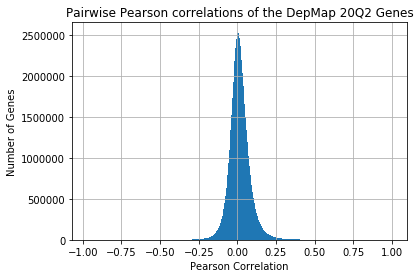

In [35]:
sorted_corrs['PCC'].hist(bins=1000)
plt.title("Pairwise Pearson correlations of the DepMap 20Q2 Genes")
plt.xlabel("Pearson Correlation")
plt.ylabel("Number of Genes")
plt.savefig('pcc_histogram')

In [133]:
#top_ten_percent = np.int(np.round(0.1*np.shape(sorted_corrs)[0]))

#sorted_corrs[['PCC']].nlargest(top_ten_percent)

In [28]:
top_ten_percent = np.int(np.round(0.1*np.shape(sorted_corrs)[0]))

16414002

In [22]:
np.shape(sorted_corrs)

(164140021, 3)

In [5]:
#sorted_corrs[(sorted_corrs.pvalue > 0.7) & (sorted_corrs.p-value < 0.8)]

In [14]:
pearsonr(dep['RFX8 (731220)'].fillna(0),dep["TBC1D8 (11138)"].fillna(0))

(0.27689410232627454, 5.307131873700017e-15)

In [15]:
pearsonr(dep['RFX8 (731220)'],dep["TBC1D8 (11138)"])

(0.27689410232627454, 5.307131873700017e-15)

In [16]:
pearsonr(dep['RFX8 (731220)'],dep["TGOLN2 (10618)"])

(0.16009665331919112, 8.150190010166789e-06)

In [7]:
corrs = corrs.rename(columns={'Unnamed: 0': 'pair','PCC':'PCC','p-value':'pvalue'})

In [6]:
#corrs[corrs.pair.str.match('A2M')]

In [55]:
#pearsonr(dep['RFXAP (5994)'].fillna(0),dep["ZUP1 (221302)"].fillna(0))

In [50]:
gene = dep.columns.to_list()
#gene

In [51]:
gene.pop(0)
#gene

'DepMap_ID'

In [31]:
# split at space
for i in range(len(gene)):
    gene[i] = gene[i].split(" ")
    

In [38]:
#gene
genes = []

for i in range(len(gene)):
    genes.append(gene[i][0])

In [40]:
len(genes)
'C8orf33' in genes

18119

In [41]:
data = pd.read_csv('/home/annerer/Downloads/elife-58925-supp2-v3.txt')

In [45]:
data = data["DMKN"].to_list()

In [7]:
# using sets to compare the lists
'''
list1 = genes
list2 = data
intersection_set = set.intersection(set(list1), set(list2))
# find intersection of list1 and list2
intersection_list = list(intersection_set)
print(intersection_list)
'''

'\n\nlist1 = genes\n\nlist2 = data\n\nintersection_set = set.intersection(set(list1), set(list2))\n\n# find intersection of list1 and list2\n\nintersection_list = list(intersection_set)\n\nprint(intersection_list)\nprint(len(intersection_list))\nprint(len(data))\n'

# Querrying the Co-Dependencies for the Cell Lines they occur in

fuer eine etwaige suche wuerde ich in Pandas die Indexe, die ich 
in Zelllinien-Namen umbenannt habe ausgebe fuer Paare in denen die Co-Dependency hoch ist. 
Dh ich habe eine Matrix. Gegeben ein Wert in einer Spalte ist hoch - gib den Index (die Zelllinie) aus. Wenn ein Wert in einer Spalte einer Co-Dependency entspricht sollte es so funktionieren.

## If this is done, the results could be checked against the genome to find if it is an oncogene addiction or not.

which files do we need for the genomes?
how do we best display them?


gives a nice overview of things i am interested in the project lab work.
relates to the big pictures systems biology context. 
good for raising awareness how many sources of errors there are.

finding new therapies for cancer.
SLIs and why RNAi and potentially also CRISPR does not deliver yet.
penetrance.

appear stable in a variety of genetic backgrounds -> high penetrance
only in very specific context -> soft penetrance

so the important factors are penetrance, 3d effects, rescue effects,
robustness (of phenotype, but in general), 



## Structure
### The Search for Synthetic Lethality in Cancer


The Problem with Synthetic Lethality: Incomplete Penetrance
 Reasons for Incomplete Penetrance
Cell Type-Specific Networks
Genetic and Epigenetic Heterogeneity




#### Experimental Approaches to Identify Highly Penetrant SLIs


#### Using Computational Approaches That Identify Highly Penetrant SLIs
##### Filtering by Using Prior Knowledge
##### Modelling Approaches To Predict SLIs
##### Extending the Applications of Highly Penetrant SLIs 
##### Using Guilt by Association

2D or Not 2D


## 5 characteristics of SLIs

Characteristic 1 – Inhibited Process Must Be Broadly Essential

Characteristic 2 – Genes Involved Must Function in Related Pathways

Characteristic 3 – Targeted Genes Must Not Have Highly Cell Type-Specific Functions

Characteristic 4 – Target Genes Should Have Few Close Paralogs

Characteristic 5 – SLIs Should Be Conserved Across Species

## Open Questions

Which biological principles determine
whether a synthetic lethal effect has
complete or incomplete penetrance?

Can these principles be determined
and used to predict highly penetrant
synthetic lethal effects?

Can model organisms (yeast, flies,
worms, mice) aid the identification of
highly penetrant SLIs? If so, which
models are most useful?

Can refined isogenic systems be
developed that better model the spectrum of mutations present in human
tumours?

Can methods be developed that allow
high-throughput perturbation screens
to be performed in vivo at a similar
scale to in vitro perturbation screens?

Can computational approaches replace
or complement empirical approaches
for defining the penetrance of synthetic
lethal effects?

o) stromal synthetic rescue

o) 3d synthetic rescue effects

o) robustness

o) Synthetic lethal penetrance: the
fraction of tumour cell clones with a
specific genetic alteration (e.g., a
cancer driver gene mutation) that
undergo cell death when an
associated synthetic lethal target is
inhibited

In [10]:
ulidata = pd.read_csv("/home/annerer/Downloads/TP53_MDM4.csv")
ulidata = ulidata['cellline'].to_list()

result = []


for _ in ulidata:
    result.append(mapping[_])
    
cellLine = result
# split at space
for i in range(len(cellLine)):
    cellLine[i] = cellLine[i].split("_") 

cell_L = []
for i in range(len(cellLine)):
    cell_L.append(cellLine[i][0])

In [27]:
ulidata = ulidata['cellline'].to_list()

In [28]:
result = []

for _ in ulidata:
    result.append(mapping[_])

In [46]:
#result

In [41]:
cellLine = result
# split at space
for i in range(len(cellLine)):
    cellLine[i] = cellLine[i].split("_") 

cellLines3 = []
for i in range(len(cellLine)):
    cellLines3.append(cellLine[i][0])

AttributeError: 'list' object has no attribute 'split'

In [45]:
new_ceL = cellLines

In [7]:
#list1 = data[data.TP53_mut_del == 1]["CCLE_NAME"].to_list()
#overlap = set.intersection(set(list1),set(cellLines))

In [ ]:
def find_correlates(gene_a,gene_b):
""" takes 2 genes and returns the cell lines
for which those two genes have a high correlation
or anticorrelation in gene effect"""

    for cola,colb in enumerate(df,2):
        diff = np.abs(cola - colb)
        summ = np.abs(cola - colb)
    